In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np 
import torch 
torch.set_default_dtype(torch.float64)

import rascaline.torch

import metatensor.torch as mts

from metatensor.torch import Labels, TensorBlock, TensorMap
from metatensor.learn import IndexedDataset, DataLoader
from metatensor.learn.data import group as mts_group, group_and_join as group_and_join_mts

from mlelec.data.dataset import QMDataset, split_by_Aij_mts
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase, kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, blocks_to_matrix_OLD, blocks_to_matrix_working, blocks_to_matrix_try, matrix_to_blocks
from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm, plot_block_errors
from mlelec.features.acdc import compute_features
from mlelec.utils.target_utils import get_targets
from mlelec.models.linear_integrated import LinearModelPeriodic
from mlelec.metrics import L2_loss, L2_loss_meanzero
from mlelec.data.mldataset import MLDataset

import xitorch
from xitorch.linalg import symeig

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
device = 'cpu'

orbitals = {
    'sto-3g': {14: [[1,0,0], [2,0,0], [3,0,0], [2,1,-1], [2,1,0], [2,1,1], [3,1,-1], [3,1,0], [3,1,1]]}, 
    'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
    'gthdzvp': {14: [[2,0,0], [3,0,0], [2,1,1], [2,1,-1], [2,1,0], [3,1,1], [3,1,-1], [3,1,0], [3,2,-2], [3,2,-1], [3,2,0], [3,2,1], [3,2,2]]},
    'gthszv':  {14: [[3,0,0], [3,1,1], [3,1,-1], [3,1,0]]}
}

# QM dataset

In [4]:
# from ase.build import bulk
# from ase import Atoms
# frames = []
# frames.append(bulk('NaCl', 'rocksalt', a = 5.7, cubic = True))
# frames.append(bulk('Si', 'diamond', a = 6, cubic = True))
# frames.append(bulk('MgO', 'zincblende', a = 4, cubic = True))
# kfock = []
# kover = []
# kmesh = [[1,2,3],[4,5,6],[1,3,5]]
# orbitals = {
#                11: [[1,0,0],[2,0,0],[3,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
#                17: [[1,0,0],[2,0,0],[3,0,0],[2,1,-1], [2,1,0],[2,1,1], [3,1,-1],[3,1,0],[3,1,1]], 
#                14: [[1,0,0],[2,0,0],[3,0,0],[2,1,-1], [2,1,0],[2,1,1], [3,1,-1],[3,1,0],[3,1,1]],
#                12: [[1,0,0],[2,0,0],[3,0,0],[2,1,-1], [2,1,0],[2,1,1]],
#                8: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
#                }
# for ifr, f in enumerate(frames):
#     nao = np.sum([len(orbitals[i]) for i in f.numbers])
#     a = torch.randn(np.prod(kmesh[ifr]), nao,nao, dtype = torch.complex128)
#     a = a+a.transpose(2,1).conj()
#     kfock.append(a)
#     b =torch.randn(np.prod(kmesh[ifr]), nao,nao, dtype = torch.complex128)
#     b = b+b.transpose(2,1)
#     kover.append(torch.einsum('aij, akj ->aik', b,b.conj()))



In [5]:
workdir = '/scratch/pegolo/silicon_deringer'
START = 0 
STOP = 1
ORBS = 'gthszv'
baseline = False

root = f'{workdir}/{ORBS}'
data_dir = root

indices = range(START,STOP)

frames = [read(f'{data_dir}/{i}/cell_{i}.xyz') for i in indices]
rfock = [np.load(f"{data_dir}/{i}/realfock_{i}.npy", allow_pickle = True).item() for i in indices]
# rfock0 = [np.load(f"{data_dir}/nscf/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
rover = [np.load(f"{data_dir}/{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in indices]
kmesh = [np.loadtxt(f'{data_dir}/{i}/kmesh_{i}.dat', dtype = np.int32).tolist() for i in indices]

if baseline:
    for H, H0 in zip(rfock, rfock0):
        for T in H:
            H[T] -= H0[T]

qmdata = QMDataset(frames = frames, 
                   kmesh = kmesh, 
                   dimension = 3,
                   fock_realspace = rfock, 
                   overlap_realspace = rover, 
                   device = device, 
                   orbs = orbitals[ORBS],
                   orbs_name = ORBS)

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.



In [6]:
max_radial  = 3
max_angular = 3
atomic_gaussian_width = 0.3
cutoff = 6

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}


hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.5,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}


return_rho0ij = False
both_centers = False
LCUT = 3

In [7]:
from mlelec.features.acdc import compute_features

In [36]:
%%timeit #-r 1 -n 1
desc1 = compute_features(qmdata, 
                         hypers_atom, 
                         hypers_pair = hypers_pair, 
                         lcut = None,
                         device = 'cpu')

cpu pair features
cpu single center features
cpu pair features
cpu single center features
cpu pair features
cpu single center features
cpu pair features
cpu single center features
cpu pair features
cpu single center features
cpu pair features
cpu single center features
cpu pair features
cpu single center features
cpu pair features
cpu single center features
1.26 s ± 26.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
import ase.io
import torch 
import metatensor.torch as mts
import rascaline.torch
from rascaline.torch.utils.clebsch_gordan import EquivariantPowerSpectrumByPair

hypers_sphex = {
    "cutoff": 4,
    "max_radial": max_radial,
    "max_angular": max_angular,
    "atomic_gaussian_width": atomic_gaussian_width,
    "center_atom_weight": 1,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
}

hypers_pair = {
    "cutoff": cutoff,
    "max_radial": max_radial,
    "max_angular": max_angular,
    "atomic_gaussian_width": atomic_gaussian_width,
    "center_atom_weight": 1,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
}
global_atom_types = [14] #3, 8, 22]  # Li, O, Ti

calc = EquivariantPowerSpectrumByPair(
    spherical_expansion_hypers=hypers_sphex,
    spherical_expansion_by_pair_hypers=hypers_pair,
    atom_types=global_atom_types,
    # selected_keys=mts.Labels(
    #     names=["o3_lambda", "o3_sigma"],
    #     values=torch.tensor([[0, 1],]),
    # )
)

In [35]:
%%timeit #-r 1 -n 1
calc = EquivariantPowerSpectrumByPair(
    spherical_expansion_hypers=hypers_sphex,
    spherical_expansion_by_pair_hypers=hypers_pair,
    atom_types=global_atom_types,
    # selected_keys=mts.Labels(
    #     names=["o3_lambda", "o3_sigma"],
    #     values=torch.tensor([[0, 1],]),
    # )
)
desc2 = calc(rascaline.torch.systems_to_torch(frames))

1.18 s ± 83.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit -r 1 -n 1


In [11]:
desc1_ = mts.rename_dimension(mts.permute_dimensions(desc1, axis = 'keys', dimensions_indexes = [0, 2, 1, 3, 4]), axis = 'keys', old = 'spherical_harmonics_l', new = 'o3_lambda')
desc1_ = mts.rename_dimension(desc1_, axis = 'keys', old = 'inversion_sigma', new = 'o3_sigma')
desc1_ = mts.rename_dimension(desc1_, axis = 'keys', old = 'species_center', new = 'first_atom_type')
desc1_ = mts.rename_dimension(desc1_, axis = 'keys', old = 'species_neighbor', new = 'second_atom_type')
# desc1_ =

In [12]:
(desc1_[0].values/desc2[0].values)[0][0][0].item()

1.7357087669593405

In [23]:
desc2[0].values.shape

torch.Size([52, 1, 36])

In [21]:
desc1_[0].values.norm()/desc2[0].values.norm()/np.sqrt(3)

tensor(0.9933)

In [52]:
m1,m2,inter=desc1_[4].samples.intersection_and_mapping(desc2[4].samples)

RuntimeError: invalid parameter: can not take the intersection of these Labels, they have different names

In [53]:
desc1_[4].samples

Labels(
    structure  center  neighbor  cell_shift_a  cell_shift_b  cell_shift_c  sign
        0        0        0           0             0             0         1
        0        0        1           0             -1            0         1
        0        0        1           0             0             0         -1
        0        0        1           0             0             0         1
        0        0        1           0             1             0         -1
        0        0        2           0             -1            0         1
        0        0        2           0             0             0         -1
        0        0        2           0             0             0         1
        0        0        2           0             1             0         -1
        0        0        3           -1            0             0         -1
        0        0        3           0             -1            0         -1
        0        0        3           0         

In [54]:
desc2[4].samples

Labels(
    system  first_atom  second_atom  cell_shift_a  cell_shift_b  cell_shift_c  sign
      0         0            1            0             -1            0         1
      0         0            1            0             0             0         -1
      0         0            1            0             0             0         1
      0         0            1            0             1             0         -1
      0         0            2            0             -1            0         1
      0         0            2            0             0             0         -1
      0         0            2            0             0             0         1
      0         0            2            0             1             0         -1
      0         0            3            -1            0             0         -1
      0         0            3            0             -1            0         -1
      0         0            3            0             0             0         -1

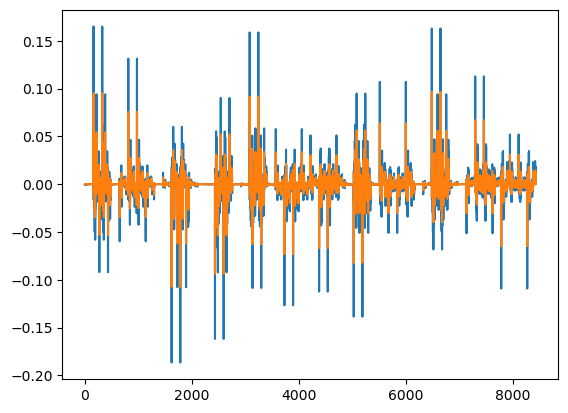

In [31]:
plt.plot(desc1_[1].values.flatten())
plt.plot(desc2[1].values.flatten())

In [25]:
for (k, b1), b2 in zip(desc1_.items(), desc2.blocks()):
    try:
        assert (b1.samples.values-b2.samples.values).to(dtype=torch.float64).norm() < 1e-10
        print(k, 'samples are fine')
        print((b1.values-b2.values).norm())
        print((b1.values.norm()/b2.values.norm()))
        print()
    except Exception as e:
        print(e)
        print(k, b1.samples.values.shape, b2.samples.values.shape)
        print()
        

LabelsEntry(order_nu=2, o3_lambda=0, o3_sigma=1, first_atom_type=14, second_atom_type=14) samples are fine
tensor(0.2887)
tensor(1.7205)

LabelsEntry(order_nu=2, o3_lambda=1, o3_sigma=1, first_atom_type=14, second_atom_type=14) samples are fine
tensor(0.5071)
tensor(1.7392)

LabelsEntry(order_nu=2, o3_lambda=2, o3_sigma=1, first_atom_type=14, second_atom_type=14) samples are fine
tensor(0.6165)
tensor(1.7232)

LabelsEntry(order_nu=2, o3_lambda=3, o3_sigma=1, first_atom_type=14, second_atom_type=14) samples are fine
tensor(0.6679)
tensor(1.7199)

LabelsEntry(order_nu=2, o3_lambda=1, o3_sigma=-1, first_atom_type=14, second_atom_type=14) samples are fine
tensor(0.5818)
tensor(1.7219)

LabelsEntry(order_nu=2, o3_lambda=2, o3_sigma=-1, first_atom_type=14, second_atom_type=14) samples are fine
tensor(0.7865)
tensor(1.7271)

LabelsEntry(order_nu=2, o3_lambda=3, o3_sigma=-1, first_atom_type=14, second_atom_type=14) samples are fine
tensor(0.8313)
tensor(1.6589)

LabelsEntry(order_nu=2, o3_lamb

In [37]:
desc1_[0].samples == desc2[0].samples

False

In [38]:
desc1_[0].samples.names

['structure',
 'center',
 'neighbor',
 'cell_shift_a',
 'cell_shift_b',
 'cell_shift_c',
 'sign']

In [39]:
desc2[0].samples.names

['system',
 'first_atom',
 'second_atom',
 'cell_shift_a',
 'cell_shift_b',
 'cell_shift_c',
 'sign']

In [ ]:
mldata = MLDataset(qmdata, 
                   item_names = ['fock_blocks', 'fock_kspace', 'overlap_kspace', 'eigenvalues'],
                   # features = mldata.features,
                   cutoff = hypers_pair['cutoff'],
                   hypers_atom = hypers_atom,
                   hypers_pair = hypers_pair,
                   lcut = 3,
                   orbitals_to_properties = True,
                   train_frac = 1.0,
                   test_frac = 0.0,
                   val_frac = 0.0)

In [ ]:
dl = DataLoader(mldata.train_dataset, batch_size = 2, 
                collate_fn = lambda x: mldata.group_and_join(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))

In [4]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = mldata.features, 
                            target_blocks = mldata.model_metadata,
                            frames = dataset.structures, 
                            orbitals = dataset.basis, 
                            device = device,
                            bias = True,
                            nhidden = 4, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )
model = model.double()

NameError: name 'LinearModelPeriodic' is not defined

### Train k matrix 

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 20)

In [23]:
phase, _, _ = precompute_phase(mts.join(mldata.items['fockblocks'], axis = 'samples', different_keys =  'union', remove_tensor_name = True), dataset, cutoff = 6)

In [ ]:
nepoch = 5000
for epoch in range(nepoch):

    epoch_loss = 0

    # Train against real space targets
    for ib, batch in enumerate(dl):
        
        model.train(True)
        optimizer.zero_grad()
        
        pred = model.forward(batch.features, mldata.model_metadata)
        # pred_k = TMap_bloch_sums(pred, phase)
        # targ_k = TMap_bloch_sums(batch.fock_blocks, phase)
        HT = blocks_to_matrix(pred, qmdata, detach = False)
        HK = [dataset.bloch_sum(HT)[ifr] for ifr in batch.sample_id]
    
        # if len(HK) == 1:
        #     overlap = [batch.overlap_kspace]
        # else:
        #     overlap = batch.overlap_kspace
            
        # pred_eigvals = [torch.stack([compute_eigval(h, s) for h, s in zip(hk, sk)]) for hk, sk in zip(HK, overlap)]
        # pred_eigvals = [torch.stack([compute_eigval(h, s) for h, s in zip(HK, batch.overlap_kspace[ifr])]) for ifr in batch.sample_id]
        # pred_eigvals = torch.stack([torch.linalg.eigvalsh(lowdin_orthogonalize(h, s)) for h, s in zip(HK, batch.overlap_kpoints)])

        # loss = loss_fn(pred_eigvals, batch.eigenvalues)
        # loss = L2_loss(pred_k, targ_k)
        # loss = L2_loss(pred_k, batch.fock_blocks)
        loss = L2_loss(HK, batch.fock_kspace)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    scheduler.step(epoch_loss)
    
    if epoch >= 0: #% 10 == 0:
        print(f"Epoch {epoch:>7d}, train loss {epoch_loss:>15.10f}") #, avg lr = {np.mean(lr_list)}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        # print(f"Epoch {epoch:>7d}, train loss {LOSS:>15.10f}, check loss {LOSSc:>15.10f}, delta {delta:>15.10f}, avg lr = {np.mean(lr_list)}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")


In [97]:
from mlelec.utils.pbc_utils import blocks_to_matrix_chat, blocks_to_matrix_claude

In [8]:
blocks = mts.join(mldata.items['fockblocks'], axis = 'samples', different_keys =  'union', remove_tensor_name = True)

In [106]:
b1 = blocks_to_matrix_claude(blocks, dataset, detach = True)

In [75]:
%%timeit
b1 = blocks_to_matrix_claude(blocks, dataset, detach = True)

2.66 s ± 50.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
%%timeit
b2 = blocks_to_matrix(blocks, dataset, detach = True)

3.12 s ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [105]:
b1[0][0,0,0]-b2[0][0,0,0]

tensor([[ 1.9309e+00,  3.6302e-04,  3.6302e-04,  3.6302e-04,  1.1282e+00,
         -1.9949e-01, -1.9949e-01, -1.9949e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 3.6302e-04,  1.2829e+00,  6.2263e-01,  6.6656e-01,  2.0100e-01,
         -3.3485e-01, -1.4470e-01, -2.0998e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 3.6302e-04,  6.2263e-01, -3.7672e-02,  6.2520e-03,  2.0100e-01,
         -1.3975e-01,  5.0396e-02, -1.4880e-02,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 3.6302e-04,  6.6656e-01,  6.2520e-03,  5.0176e-02,  2.0100e-01,
         -1.9634e-01, -6.1887e-03, -7.1465e-02,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.1282e+00

In [89]:
b1 = blocks_to_matrix_claude(blocks, dataset, detach = True)
b2 = blocks_to_matrix(blocks, dataset, detach = True)

In [111]:
%%timeit
b1 = blocks_to_matrix_claude(blocks, dataset, detach = True)

1.79 s ± 25.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [88]:
%%timeit
b2 = blocks_to_matrix(blocks, dataset, detach = True)

3.12 s ± 7.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [109]:
%lprun -f blocks_to_matrix_claude blocks_to_matrix_claude(blocks, dataset, detach = True)

Timer unit: 1e-09 s

Total time: 2.31562 s
File: /home/pegolo/Software/mlelec/src/mlelec/utils/pbc_utils.py
Function: blocks_to_matrix_claude at line 1880

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1880                                           def blocks_to_matrix_claude(blocks, dataset, device=None, cg=None, all_pairs=False, sort_orbs=True, detach=False, sample_id=None):
  1881         1        501.0    501.0      0.0      if device is None:
  1882         1        792.0    792.0      0.0          device = dataset.device
  1883                                                   
  1884         1      95811.0  95811.0      0.0      if "L" in blocks.keys.names:
  1885         1       2695.0   2695.0      0.0          from mlelec.utils.twocenter_utils import _to_uncoupled_basis
  1886         1   36550664.0    4e+07      1.6          blocks = _to_uncoupled_basis(blocks, cg=cg, device=device)
  1887                                           
  1888         1      11

In [112]:
for b1_, b2_ in zip(b1, b2):
    for T in b1_:
        assert (b1_[T]-b2_[T]).norm() < 1e-10

In [478]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 20)

### Train eigvals

In [479]:
from mlelec.metrics import Eigval_loss, L2_loss_meanzero, L2_loss
loss_fn = Eigval_loss #L2_loss #_meanzero

In [480]:
def compute_eigval(A, M):
    Ax = xitorch.LinearOperator.m(A)
    Mx = xitorch.LinearOperator.m(M) if M is not None else None

    # Compute eigenvalues and eigenvectors
    eigvals, eigvecs = symeig(Ax, M = Mx)
    return eigvals

In [481]:
nepoch = 5000
for epoch in range(nepoch):

    epoch_loss = 0
    # Train against real space targets
    for ib, batch in enumerate(dl):
        
        model.train(True)
        optimizer.zero_grad()
        # for ik, key in enumerate(model.model):
        #     optimizers[ik].zero_grad()
        
        pred = model.forward(batch.features, mldata.model_metadata)
        HT = blocks_to_matrix(pred, dataset, detach = False)
        HK = [dataset.bloch_sum(HT)[ifr] for ifr in batch.sample_id] #+ batch.baseline
        if len(HK) == 1:
            overlap = [batch.overlap_kspace]
        else:
            overlap = batch.overlap_kspace
            
        pred_eigvals = [torch.stack([compute_eigval(h, s) for h, s in zip(hk, sk)]) for hk, sk in zip(HK, overlap)]
        # pred_eigvals = [torch.stack([compute_eigval(h, s) for h, s in zip(HK, batch.overlap_kspace[ifr])]) for ifr in batch.sample_id]
        # pred_eigvals = torch.stack([torch.linalg.eigvalsh(lowdin_orthogonalize(h, s)) for h, s in zip(HK, batch.overlap_kpoints)])

        loss = loss_fn(pred_eigvals, batch.eigenvalues)
        loss.backward()
        optimizer.step()
        # for i, (l, o) in enumerate(zip(all_losses, optimizers)):
        #     l.backward(retain_graph = False)
        #     o.step()

        epoch_loss += loss.item()
    
    scheduler.step(epoch_loss)
    # for s in schedulers:
    #     s.step(l.item())
        # lr_list.append(s.get_last_lr())

    
        # if scheduler.get_last_lr(), lr):
        #     lr = scheduler.get_last_lr()
        #     print(f'lr changed to {lr}')

    # LOSS_LIST.append(LOSS)
    # LOSS_LISTc.append(LOSSc)
    if epoch >= 0: #% 10 == 0:
        print(f"Epoch {epoch:>7d}, train loss {epoch_loss:>15.10f}") #, avg lr = {np.mean(lr_list)}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        # print(f"Epoch {epoch:>7d}, train loss {LOSS:>15.10f}, check loss {LOSSc:>15.10f}, delta {delta:>15.10f}, avg lr = {np.mean(lr_list)}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")


Epoch       0, train loss 53597.0918419704
Epoch       1, train loss 44175.1499621223
Epoch       2, train loss 36248.1691240230
Epoch       3, train loss 28370.4101911453
Epoch       4, train loss 21438.2034891949
Epoch       5, train loss 15807.1415780888
Epoch       6, train loss 11985.5146603819
Epoch       7, train loss 9774.8678498762
Epoch       8, train loss 8501.8504699509
Epoch       9, train loss 7450.2254457610
Epoch      10, train loss 6335.8788934897
Epoch      11, train loss 5493.2822659648
Epoch      12, train loss 4935.4310709653
Epoch      13, train loss 4454.4759109243
Epoch      14, train loss 4122.9358574417
Epoch      15, train loss 3884.2145714118
Epoch      16, train loss 3698.7704982252
Epoch      17, train loss 3556.6680679591
Epoch      18, train loss 3441.0080173714
Epoch      19, train loss 3336.5085425173
Epoch      20, train loss 3242.5222185971
Epoch      21, train loss 3149.1740489903
Epoch      22, train loss 3068.0809865005
Epoch      23, train loss 2

KeyboardInterrupt: 